# Определение возраста покупателей

## Исследовательский анализ данных

### Загрузка и анализ данных

In [226]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [185]:
labels_path = '/datasets/faces/labels.csv'
images_dir = '/datasets/faces/final_files/'

Загрузим таблицу изображение-возраст.

In [85]:
labels = pd.read_csv(labels_path)

Первые 15 строк загруженной таблицы.

In [157]:
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Размер выборки (количество строк таблицы).

In [87]:
len(labels)

7591

Описательная статистика столбца со значением возраста человека на фотографии.

In [195]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

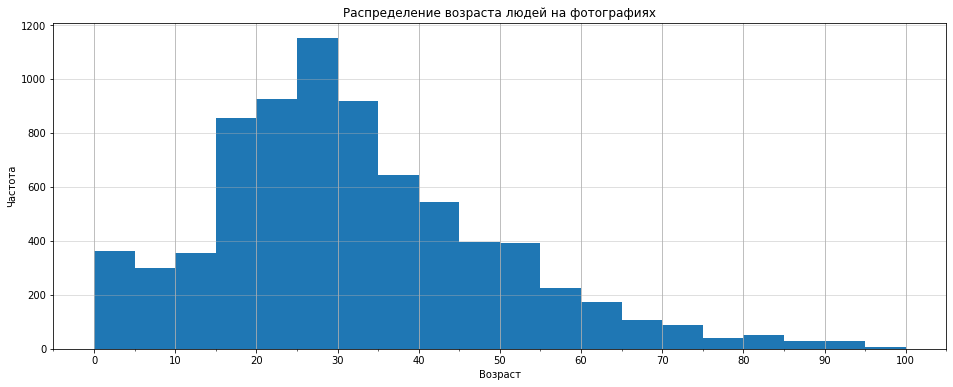

In [253]:
ax = labels.real_age.plot.hist(
    bins=range(0, labels.real_age.max() + 5, 5),
    grid='on',
    figsize=(16, 6)
);
ax.grid(which='both', axis='y', alpha=0.5);
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10));
ax.set_ylabel('Частота');
ax.set_xlabel('Возраст');
ax.set_title('Распределение возраста людей на фотографиях');
plt.show()

На фотографиях запечатлены люди в возрасте от 1 года до 100 лет. Распределение близко имеет куполообразную форму с хвостом в области максимальных значений. Основная масса фотографий приходится на людей в возрасте от 15-45 лет.


Загрузим изображения. Выведем первые 15 фотографий.

In [186]:
datagen = ImageDataGenerator(rescale=1/255.)
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=images_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=15,
    class_mode='raw',
    shuffle=False, # Убрать на этапе обучения
    seed=12345)

Found 7591 validated image filenames.


In [187]:
features, target = next(train_datagen_flow)

Таргеты. Первые 15.

In [191]:
target

array([ 4, 18, 80, 50, 17, 27, 24, 43, 26, 39, 17, 51,  2,  1,  6])

Целевые признаки совпадают с таблицей. Данные загрузились корректно.

Соответствующие им изображения.

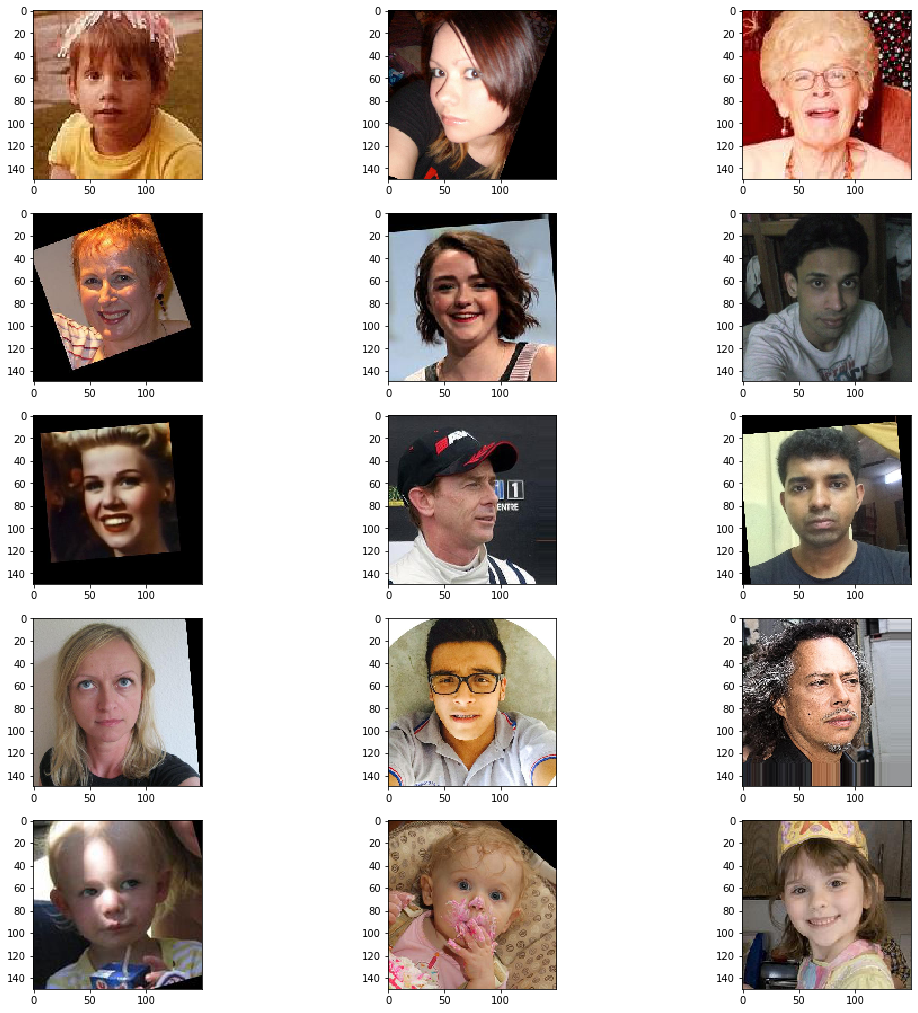

In [188]:
fig = plt.figure(figsize=(18, 18))
for i, image in enumerate(features, 1):
    fig.add_subplot(5, 3, i)
    plt.imshow(image)
plt.show()

## Обучение модели

Код обучения модели.

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

def load_train(path):
    p = path if path[-1] == '/' else path + '/' # Добавляет '/' в конец path, если нет
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(p + 'labels.csv'),
        directory=p + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        shuffle=False, # По умолчанию True, добавлено для повторяемость результата
        seed=12345)

    return train_datagen_flow


def load_test(path):
    p = path if path[-1] == '/' else path + '/'
    
    valid_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(p + 'labels.csv'),
        directory=p + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=False, # По умолчанию True
        seed=12345)

    return valid_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', # 'imagenet'
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0002)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae'])  # mean_squared_error    mean_absolute_error

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

Вывод процесса обучения модели.

```python

Train for 178 steps, validate for 60 steps

Epoch 1/5

178/178 - 46s - loss: 205.1778 - mae: 10.4612 - val_loss: 824.5940 - val_mae: 23.9119

Epoch 2/5

178/178 - 38s - loss: 73.5695 - mae: 6.5245 - val_loss: 579.6293 - val_mae: 19.1324

Epoch 3/5

178/178 - 38s - loss: 42.3135 - mae: 4.9868 - val_loss: 489.1448 - val_mae: 17.0582

Epoch 4/5

178/178 - 38s - loss: 27.2952 - mae: 4.0534 - val_loss: 148.1043 - val_mae: 9.0222

Epoch 5/5

178/178 - 38s - loss: 17.4351 - mae: 3.2330 - val_loss: 73.3111 - val_mae: 6.4252

60/60 - 10s - loss: 73.3111 - mae: 6.4252

Test MAE: 6.4252


```

## Анализ обученной модели

Решена регрессионная задача определения возраста человека по его портретной фотографии. Для ее решения обучена нейронная сеть **ResNet50**, последний слой которой был заменен на перцептрон с функцией активации **ReLu**, являющейся линейной в области положительных значений.

Для обучения использовался алгоритм **Adam** со значением **learning rate** = 0.0002. В качестве функции потерь использовалась **MSE**, метрики качества &mdash; **MAE**. Обучение осуществлялось за 5 эпох. Достигнутое значение метрики качества **MAE** составило 6.4252.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы